In this notebook, we perform feature analysis on XGBoost models applied on the dataset that has only records of patients with no memory complaints.  
We use the tuned versions of both models. 

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style

set_style("whitegrid")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score

In [3]:
## Loading the dataset
df_train = pd.read_csv("../../data/train_set.csv")

## Restricting to patients with NoMemoryComplaints
df_train = df_train.loc[df_train.MemoryComplaints == 0]

## Dropping redundant columns
df_train = df_train.drop(columns = ['DoctorInCharge' , 'PatientID' ])

In [4]:
## Seperating features into subcategories

all_features = ['Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI',
               'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
               'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease',
               'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP',
               'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
               'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
               'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion',
               'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
               'Forgetfulness' , 'Diagnosis']
demo_features = ['Age', 'Gender', 'Ethnicity','EducationLevel','Diagnosis']
life_style_features = ['BMI','Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality','Diagnosis']
medic_hist_features = ['FamilyHistoryAlzheimers', 'CardiovascularDisease','Diabetes', 'Depression', 'HeadInjury', 'Hypertension','Diagnosis']
clinical_features = ['SystolicBP','DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL','CholesterolTriglycerides','Diagnosis']
cognitive_features = ['MMSE', 'FunctionalAssessment','MemoryComplaints', 'BehavioralProblems', 'ADL','Diagnosis']
symptoms_features = ['Confusion','Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks','Forgetfulness','Diagnosis']

no_cognitive = [item for item in all_features if item not in cognitive_features]
no_cognitive.append('Diagnosis')

subcategory_dict = {'all_features' : all_features,'demo':demo_features ,'lifestyle': life_style_features , 'medic' : medic_hist_features , 
                    'clinical':clinical_features , 'cognitive': cognitive_features , 'symptoms': symptoms_features , 'no_cognitive': no_cognitive}


In [5]:
# Define colors for feature categories
category_colors = {
    "Demographics": "green",
    "Lifestyle": "orange",
    "Medical History": "blue",
    "Clinical Measurements": "purple",
    "Cognitive Assesments": "pink",
    "Symptoms": "yellow"  
}

# Mapping features to their categories
feature_categories = {
    **{feature: "Demographics" for feature in demo_features},
    **{feature: "Lifestyle" for feature in life_style_features},
    **{feature: "Medical History" for feature in medic_hist_features},
    **{feature: "Clinical Measurements" for feature in clinical_features},
    **{feature: "Cognitive Assesments" for feature in cognitive_features}
}

##### **Feature Importance for Adaboost model**

In [7]:
# Best params from tuning
model_tuned_tree_params = {
    'criterion': 'entropy',
    'max_depth': 4,
    'min_samples_split': 8
}
model_tuned_ada_params = {
    'n_estimators': 155,
    'learning_rate': 0.10565064269531074,
    'algorithm': 'SAMME'
}

In [8]:
# Tuned AdaBoost model for the entire dataset
model0 = AdaBoostClassifier(
    **model_tuned_ada_params,
    estimator=DecisionTreeClassifier(**model_tuned_tree_params, random_state=123),
    random_state=123
)
model0.fit(df_train[all_features[:-1]],df_train.Diagnosis)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(criterion='entropy',
                                                    max_depth=4,
                                                    min_samples_split=8,
                                                    random_state=123),
                   learning_rate=0.10565064269531074, n_estimators=155,
                   random_state=123)

In [9]:
#Compute feature important scores
importances = model0.feature_importances_
indices = np.flip(np.argsort(importances))

sorted_features = [all_features[i] for i in indices]  #features sorted in descending order according to importance
sorted_importances = importances[indices]  #importance scores sorted in descending order


# Assign colors to the features
sorted_colors = [
    category_colors.get(feature_categories.get(feature, "Symptoms"), "yellow")
    for feature in sorted_features
]

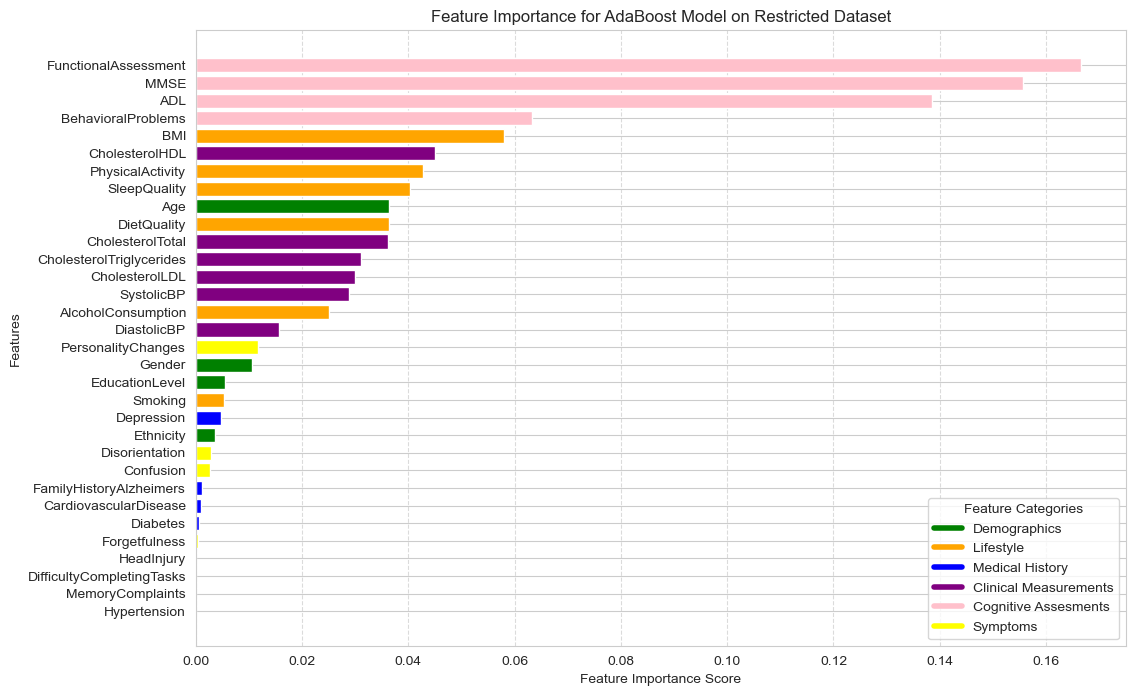

In [10]:
# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(sorted_features, sorted_importances, align='center', color=sorted_colors)
plt.title("Feature Importance for AdaBoost Model on Restricted Dataset")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(loc='lower right', handles=[plt.Line2D([0], [0], color=color, lw=4, label=label) 
for label, color in category_colors.items()],
               title="Feature Categories")
plt.show()

### **Feature Importance for Tuned XGBoost model**


In [12]:
# Best params from tuning.  I used tuned model 6 parameters
model_params = {
    'n_estimators': 342, 
    'learning_rate': 0.2936557853809352,
    'max_depth': 4, 
    'min_child_weight': 2, 
    'gamma': 3, 
    'subsample': 0.9505333790576483,
    'colsample_bytree': 0.6024713590870578,
    'reg_alpha': 0.22059934204998982, 
    'reg_lambda': 0.8737784998045829, 
    'scale_pos_weight': 1, 
    'eval_metric': 'error'
}

In [13]:
model1 = XGBClassifier(**model_params,random_state=123)
model1.fit(df_train[all_features[:-1]],df_train.Diagnosis)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6024713590870578, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='error', feature_types=None, feature_weights=None,
              gamma=3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2936557853809352,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=342, n_jobs=None,
              num_parallel_tree=None, ...)

In [14]:
#Compute feature important scores
importances = model1.feature_importances_
indices = np.flip(np.argsort(importances))

sorted_features = [all_features[i] for i in indices]  #features sorted in descending order according to importance
sorted_importances = importances[indices]  #importance scores sorted in descending order


# Assign colors to the features
sorted_colors = [
    category_colors.get(feature_categories.get(feature, "Symptoms"), "yellow")
    for feature in sorted_features
]

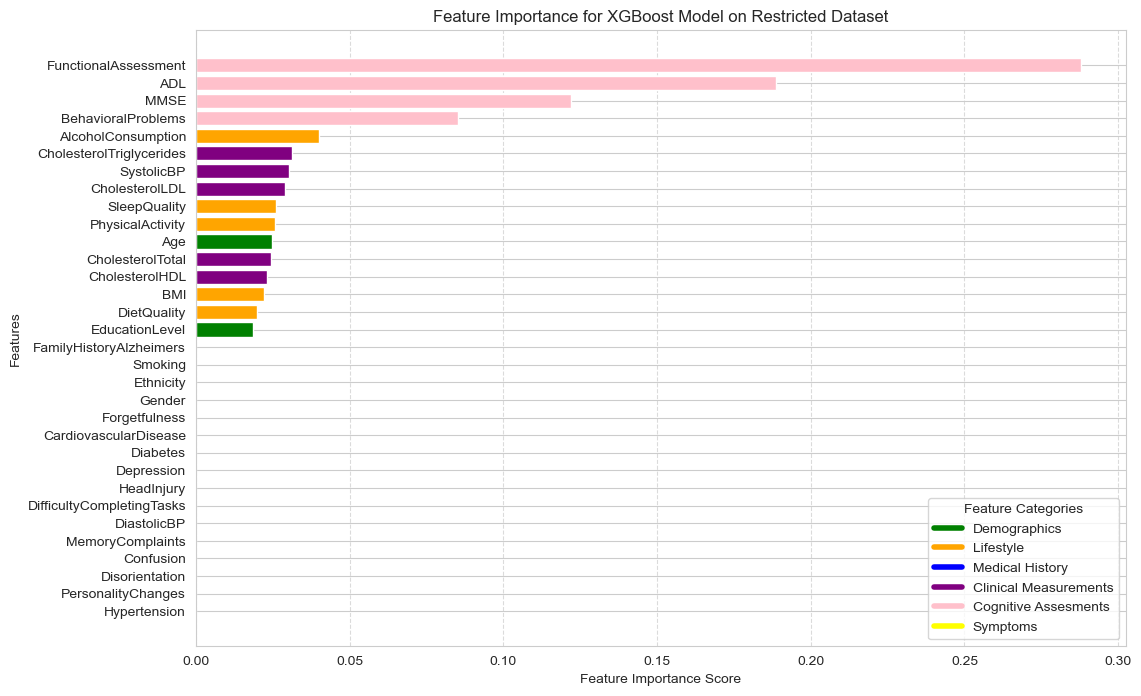

In [15]:
# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(sorted_features, sorted_importances, align='center', color=sorted_colors)
plt.title(f"Feature Importance for XGBoost Model on Restricted Dataset")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(loc='lower right', handles=[plt.Line2D([0], [0], color=color, lw=4, label=label) 
for label, color in category_colors.items()],
               title="Feature Categories")
plt.show()